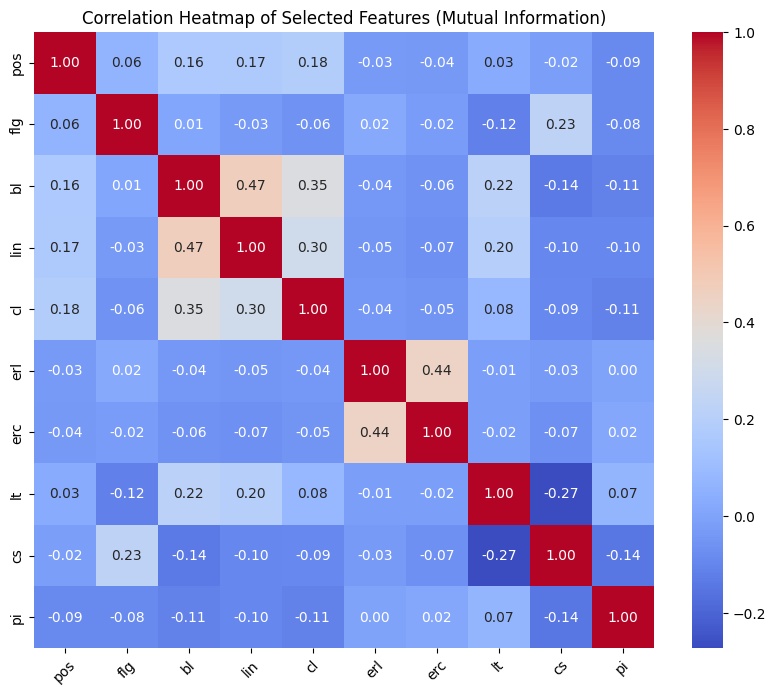

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Load dataset
file_path = 'user_fake_authentic_2class.csv'  
data = pd.read_csv(file_path)

# Fill missing values
data.fillna(0, inplace=True)

# Encode target variable
data['class'] = LabelEncoder().fit_transform(data['class'])

# Define features and target
X = data.drop('class', axis=1)
y = data['class']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled features back to a DataFrame with original column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Feature Selection with Mutual Information
selector = SelectKBest(mutual_info_classif, k=10)
X_selected = selector.fit_transform(X_scaled_df, y) 

# Get selected feature names
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_scaled_df.columns[selected_feature_indices]

# Create a correlation matrix for the selected features
correlation_matrix = X_scaled_df[selected_feature_names].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap of Selected Features (Mutual Information)")
plt.xticks(rotation=45)
plt.show()


In [11]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees
    'max_depth': [5, 10, 15],        # Maximum depth of trees
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1',  # Optimize for F1-score
    n_jobs=-1      # Use all CPU cores
)

# Run Grid Search
grid_search.fit(X_selected, y)

# Get the best parameters and score
grid_best_params = grid_search.best_params_
grid_best_score = grid_search.best_score_

print("Grid Search complete. Best parameters:", grid_best_params)
print("Best F1-Score from Grid Search:", grid_best_score)


Grid Search complete. Best parameters: {'max_depth': 10, 'n_estimators': 100}
Best F1-Score from Grid Search: 0.891284484230019


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

def fitness_function(params):
    n_estimators = int(params[0])  # Number of trees
    max_depth = int(params[1])     # Depth of each tree
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return f1_score(y_test, y_pred)


In [14]:
import numpy as np

class BilliardOptimization:
    def __init__(self, fitness_func, bounds, population_size=20, iterations=30):
        self.fitness_func = fitness_func
        self.bounds = bounds
        self.population_size = population_size
        self.iterations = iterations
        self.population = None
        self.best_solution = None
        self.best_score = float('-inf')

    def initialize_population(self):
        self.population = np.random.uniform(
            self.bounds[0], self.bounds[1], (self.population_size, len(self.bounds[0]))
        )

    def evaluate(self):
        fitness = np.apply_along_axis(self.fitness_func, 1, self.population)
        max_fitness_idx = np.argmax(fitness)
        if fitness[max_fitness_idx] > self.best_score:
            self.best_score = fitness[max_fitness_idx]
            self.best_solution = self.population[max_fitness_idx]
        return fitness

    def update_positions(self, fitness):
        velocities = np.random.uniform(-1, 1, self.population.shape)
        self.population += velocities
        for i in range(self.population_size):
            for j in range(self.population.shape[1]):
                if self.population[i, j] < self.bounds[0][j]:
                    self.population[i, j] = self.bounds[0][j]
                if self.population[i, j] > self.bounds[1][j]:
                    self.population[i, j] = self.bounds[1][j]

    def optimize(self):
        self.initialize_population()
        for iteration in range(self.iterations):
            print(f"Iteration {iteration + 1}/{self.iterations}")
            
            # Log current parameters being tested
            print("Current Parameters Being Tested:")
            for params in self.population:
                print(f"n_estimators={int(params[0])}, max_depth={int(params[1])}")

            fitness = self.evaluate()
            print(f"Best F1-Score so far: {self.best_score:.4f}\n")
            self.update_positions(fitness)
        return self.best_solution, self.best_score

# Define hyperparameter bounds
bounds = ([50, 5], [200, 20])  # n_estimators (50 to 200), max_depth (5 to 20)

# Define the fitness function
def fitness_function(params):
    n_estimators, max_depth = map(int, params)
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

# Apply BOA
boa = BilliardOptimization(fitness_function, bounds, population_size=20, iterations=30)
best_params, best_score = boa.optimize()

print("Best Parameters:", best_params)
print("Best F1-Score:", best_score)




Iteration 1/30
Current Parameters Being Tested:
n_estimators=142, max_depth=13
n_estimators=187, max_depth=14
n_estimators=72, max_depth=19
n_estimators=128, max_depth=18
n_estimators=93, max_depth=18
n_estimators=90, max_depth=10
n_estimators=78, max_depth=15
n_estimators=165, max_depth=11
n_estimators=117, max_depth=10
n_estimators=141, max_depth=17
n_estimators=133, max_depth=17
n_estimators=79, max_depth=12
n_estimators=163, max_depth=8
n_estimators=137, max_depth=11
n_estimators=55, max_depth=12
n_estimators=68, max_depth=11
n_estimators=142, max_depth=16
n_estimators=198, max_depth=13
n_estimators=168, max_depth=12
n_estimators=139, max_depth=7
Best F1-Score so far: 0.8935

Iteration 2/30
Current Parameters Being Tested:
n_estimators=141, max_depth=13
n_estimators=187, max_depth=15
n_estimators=72, max_depth=19
n_estimators=129, max_depth=17
n_estimators=92, max_depth=17
n_estimators=89, max_depth=10
n_estimators=77, max_depth=15
n_estimators=164, max_depth=11
n_estimators=117, m

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Best parameters (from optimization process)
best_params = [187.37331156, 16.32423008]

# Convert parameters to integers
n_estimators = int(best_params[0])
max_depth = int(best_params[1])

# Train final model
final_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
final_model.fit(X_train, y_train)

# Predictions
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-Score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_proba),
}

print("Evaluation Metrics:", metrics)


Evaluation Metrics: {'Accuracy': 0.8868054492576152, 'Precision': np.float64(0.8378598587724063), 'Recall': np.float64(0.9558481797056545), 'F1-Score': np.float64(0.8929734423619654), 'ROC-AUC': np.float64(0.9520278328692139)}
